## Creating a dataset

The main purpose of this notebook is to combine a few datasets of interest to our project into a single one with the aim of creating a minimal working example and a baseline model. I had to make some options throughout the process, and some have some shortcomings that we will have to address. For instance, I am using all the data available for a given street when creating a model, but some features of a street change with time (perhaps some speed humps were installed last year in the street we are studying). Any model based on the dataset created in this notebook will ignore this considerations. 

The baseline model and MWE will both try to estimate the number of crashes occurring in a given street of NYC, at a given time of day during the period of one month.

The only data sources used were the ones from the NYC OpenData project. The datasets are directly loaded into memory at the start of the notebook. I used GeoPandas to join these atasets. Joining by the road name is not reliable, as the road names are not uniform across different datasets. (They are not even uniform WITHIN the crash dataset.) Moreover, not all datasets include road names.

One thing that I want to do soon is to create a class with methods that streamline this whole data engineering process. At the moment, it is rather cumbersome to use this notebook for data wrangling. A centralized set of methods to reduce boilerplate code would likely improve our efficiency.

In [29]:
import geopandas as gpd
import pandas as pd
import numpy as np

It seems that endpoints change frequently, so these variables may need to be updated regularly.

In [30]:
CRASHES_ENDPOINT = "h9gi-nx95"
CENTERLINE_ENDPOINT = "8rma-cm9c"
SPEEDLIMITS_ENDPOINT = "e3v7-wxpr"
SPEEDHUMPS_ENDPOINT = "ngwe-6c39"

In [31]:
from data_downloader import OpenDataDownloader
from dotenv import load_dotenv
import os

load_dotenv()

nyc_app_token = os.getenv("NYC_OPENDATA_APPTOKEN")

data_loader = OpenDataDownloader(nyc_app_token)

In [32]:
crashes = data_loader.load_data(CRASHES_ENDPOINT, limit=3000000)

In [33]:
NYC_EPSG = "EPSG:2263"
STD_EPSG = "EPSG:4326"

centerline = data_loader.load_geo_dataframe(
    CENTERLINE_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)
speed_lims = data_loader.load_geo_dataframe(
    SPEEDLIMITS_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)
humps = data_loader.load_geo_dataframe(
    SPEEDHUMPS_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)

In [34]:
crashes.columns

Index(['crash_date', 'crash_time', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5'],
      dtype='object')

In [35]:
crashes_cols_keep = ["crash_date", "crash_time", "latitude", "longitude"]

In [36]:
centerline.columns

Index(['physicalid', 'l_zip', 'r_zip', 'l_blkfc_id', 'r_blkfc_id', 'st_label',
       'status', 'borocode', 'st_width', 'created', 'modified', 'trafdir',
       'rw_type', 'frm_lvl_co', 'to_lvl_co', 'snow_pri', 'post_type',
       'full_stree', 'st_name', 'segment_ty', 'shape_leng', 'l_low_hn',
       'l_high_hn', 'r_low_hn', 'r_high_hn', 'pre_direct', 'bike_lane',
       'bike_trafd', 'post_direc', 'pre_type', 'post_modif', 'pre_modifi',
       'geometry'],
      dtype='object')

In [37]:
centerline_cols_keep = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "st_width",
]

In [38]:
speed_lims.columns

Index(['street', 'postvz_sl', 'postvz_sg', 'shape_leng', 'geometry'], dtype='object')

In [39]:
speed_cols_keep = ["postvz_sl", "geometry"]

In [40]:
humps.columns

Index(['on_street', 'from_stree', 'to_street', 'humps', 'date_insta',
       'shape_leng', 'geometry'],
      dtype='object')

In [41]:
humps_cols_keep = ["humps", "geometry"]

For the sake of this example, I will only keep a few columns. There are several other features of this dataset that we may be interested about. For instance, we may want to know how many people died in a given car crash so that we can rank each in terms of its severity.

In [42]:
columns_to_keep = ["crash_date", "crash_time", "latitude", "longitude"]

In [43]:
crashes_trim = crashes[columns_to_keep]
centerline_trim = centerline[centerline_cols_keep]
speed_lims_trim = speed_lims[speed_cols_keep]
humps_trim = humps[humps_cols_keep]

We can only work with rows with non-null latitude and longitude entries.

In [44]:
crashes_trim = crashes_trim.dropna(subset=["longitude", "latitude"])
crashes_trim.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1840642 entries, 3 to 2074191
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   crash_date  1840642 non-null  object
 1   crash_time  1840642 non-null  object
 2   latitude    1840642 non-null  object
 3   longitude   1840642 non-null  object
dtypes: object(4)
memory usage: 70.2+ MB


In [45]:
crashes_gdf = gpd.GeoDataFrame(
    crashes_trim,
    geometry=gpd.points_from_xy(crashes_trim["longitude"], crashes_trim["latitude"]),
    crs=STD_EPSG,
)

crashes_gdf.to_crs(NYC_EPSG, inplace=True)

In [46]:
import datetime


def create_datetime_feature(row: pd.DataFrame) -> datetime.datetime:
    year, month, day = list(map(int, row["crash_date"].split("T")[0].split("-")))
    hour, minute = list(map(int, row["crash_time"].split(":")))
    return datetime.datetime(year, month, day, hour, minute)

In [47]:
crashes_gdf["datetime"] = crashes_gdf[["crash_date", "crash_time"]].apply(
    create_datetime_feature, axis=1
)

In [48]:
crashes_gdf.drop(columns=["crash_date", "crash_time"], inplace=True)

In [49]:
centerline_trim.geometry.value_counts()

geometry
MULTILINESTRING ((1020363.754 220509.997, 1020...    2
MULTILINESTRING ((995384.564 237575.420, 99550...    2
MULTILINESTRING ((995508.586 237801.167, 99563...    2
MULTILINESTRING ((995634.569 238028.993, 99575...    2
MULTILINESTRING ((995222.714 237284.193, 99525...    2
                                                    ..
MULTILINESTRING ((980967.070 191446.957, 98088...    1
MULTILINESTRING ((959813.450 174070.377, 95979...    1
MULTILINESTRING ((993185.034 232807.373, 99318...    1
MULTILINESTRING ((997111.937 235749.663, 99710...    1
MULTILINESTRING ((1009309.441 248021.379, 1009...    1
Name: count, Length: 121678, dtype: int64

There are several duplicated roads in the `centerline` dataset. Perhaps each corresponds to a direction of traffic? For now, I will only keep the first copy.

In [50]:
centerline_trim = centerline_trim.drop_duplicates(subset=["geometry"])

In [51]:
def add_centroids(df: pd.DataFrame):
    df["centroid"] = df.geometry.centroid
    df.rename(columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True)
    df.drop(columns="road_geom", inplace=True)

In [52]:
add_centroids(speed_lims_trim)
add_centroids(humps_trim)

/home/pjlemos/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_110062/670079779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True)
/tmp/ipykernel_110062/670079779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [55]:
centerline_trim["buffered"] = centerline.geometry.buffer(32)
centerline_trim.rename(
    columns={"geometry": "road_geom", "buffered": "geometry"}, inplace=True
)

In [56]:
road_info = centerline_trim.sjoin(speed_lims_trim, how="left")

In [57]:
road_info.columns

Index(['rw_type', 'bike_lane', 'shape_leng', 'trafdir', 'road_geom',
       'st_width', 'geometry', 'index_right', 'postvz_sl'],
      dtype='object')

In [58]:
road_info.drop(
    columns=["index_right"], inplace=True
)

In [59]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261196 entries, 0 to 121905
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     261196 non-null  object  
 1   bike_lane   35825 non-null   object  
 2   shape_leng  261196 non-null  object  
 3   trafdir     261157 non-null  object  
 4   road_geom   261196 non-null  geometry
 5   st_width    261196 non-null  object  
 6   geometry    261196 non-null  geometry
 7   postvz_sl   247500 non-null  object  
dtypes: geometry(2), object(6)
memory usage: 17.9+ MB


For the moment, I will fill null values in the speed limit column with the mode.

In [60]:
speed_lim_mode = road_info.postvz_sl.mode().iloc[0]
speed_lim_mode

'25'

In [61]:
road_info["postvz_sl"] = road_info["postvz_sl"].fillna(speed_lim_mode)

In [62]:
road_info["postvz_sl"] = road_info["postvz_sl"].astype(int)

In [63]:
road_info = road_info.groupby(
    by=[
        "rw_type",
        "bike_lane",
        "shape_leng",
        "trafdir",
        "geometry",
        "road_geom",
        "st_width",
    ],
    dropna=False,
    as_index=False,
)["postvz_sl"].mean()

In [64]:
road_info.columns

Index(['rw_type', 'bike_lane', 'shape_leng', 'trafdir', 'geometry',
       'road_geom', 'st_width', 'postvz_sl'],
      dtype='object')

In [65]:
# Group bys turn geo dataframes into regular dataframes

road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [66]:
road_info = road_info.sjoin(humps_trim, how="left")

In [67]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121815 entries, 0 to 121677
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   rw_type      121815 non-null  object  
 1   bike_lane    15688 non-null   object  
 2   shape_leng   121815 non-null  object  
 3   trafdir      121805 non-null  object  
 4   geometry     121815 non-null  geometry
 5   road_geom    121815 non-null  geometry
 6   st_width     121815 non-null  object  
 7   postvz_sl    121815 non-null  float64 
 8   index_right  4209 non-null    float64 
 9   humps        4209 non-null    object  
dtypes: float64(2), geometry(2), object(6)
memory usage: 10.2+ MB


In [68]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((989093.930 202786.694, 98946...    3
MULTILINESTRING ((1038682.193 153036.382, 1038...    3
MULTILINESTRING ((1033263.313 151248.859, 1033...    3
MULTILINESTRING ((1033693.814 151394.453, 1033...    3
MULTILINESTRING ((996027.614 193097.200, 99614...    3
                                                    ..
MULTILINESTRING ((1031512.607 181747.213, 1031...    1
MULTILINESTRING ((991015.416 200270.174, 99113...    1
MULTILINESTRING ((1026875.484 208891.584, 1026...    1
MULTILINESTRING ((1010806.216 218841.206, 1010...    1
MULTILINESTRING ((1005012.180 230583.954, 1005...    1
Name: count, Length: 121678, dtype: int64

In [70]:
columns_to_groupby = list(road_info.columns)
columns_to_groupby.remove("index_right")
columns_to_groupby.remove("humps")
columns_to_groupby

['rw_type',
 'bike_lane',
 'shape_leng',
 'trafdir',
 'geometry',
 'road_geom',
 'st_width',
 'postvz_sl']

In [71]:
road_info["humps"] = road_info["humps"].fillna(0)
road_info["humps"] = road_info["humps"].astype(float)

In [72]:
road_info = road_info.groupby(by=columns_to_groupby, as_index=False, dropna=False)[
    "humps"
].sum()

In [74]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [75]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((979522.293 189565.875, 97863...    1
MULTILINESTRING ((1033288.969 251636.684, 1033...    1
MULTILINESTRING ((993165.517 198810.190, 99316...    1
MULTILINESTRING ((982782.907 198677.700, 98279...    1
MULTILINESTRING ((934739.005 166936.419, 93474...    1
                                                    ..
MULTILINESTRING ((1015581.752 267292.839, 1015...    1
MULTILINESTRING ((983378.113 198714.222, 98340...    1
MULTILINESTRING ((983470.612 186474.070, 98351...    1
MULTILINESTRING ((974902.903 160965.516, 97490...    1
MULTILINESTRING ((1025923.485 240757.785, 1026...    1
Name: count, Length: 121678, dtype: int64

In [76]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121678 entries, 0 to 121677
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     121678 non-null  object  
 1   bike_lane   15673 non-null   object  
 2   shape_leng  121678 non-null  object  
 3   trafdir     121668 non-null  object  
 4   geometry    121678 non-null  geometry
 5   road_geom   121678 non-null  geometry
 6   st_width    121678 non-null  object  
 7   postvz_sl   121678 non-null  float64 
 8   humps       121678 non-null  float64 
dtypes: float64(2), geometry(2), object(5)
memory usage: 8.4+ MB


In [77]:
crashes_road = road_info.sjoin(crashes_gdf, how="left")

In [78]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6258787 entries, 0 to 121677
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   rw_type      6258787 non-null  object        
 1   bike_lane    1269168 non-null  object        
 2   shape_leng   6258787 non-null  object        
 3   trafdir      6258247 non-null  object        
 4   geometry     6258787 non-null  geometry      
 5   road_geom    6258787 non-null  geometry      
 6   st_width     6258787 non-null  object        
 7   postvz_sl    6258787 non-null  float64       
 8   humps        6258787 non-null  float64       
 9   index_right  6235341 non-null  float64       
 10  latitude     6235341 non-null  object        
 11  longitude    6235341 non-null  object        
 12  datetime     6235341 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(2), object(7)
memory usage: 668.5+ MB


In [79]:
crashes_road.drop(columns=["index_right"], inplace=True)

In [80]:
crashes_road.reset_index(inplace=True)
crashes_road.drop(columns=["index"], inplace=True)

In [81]:
crashes_road.head()

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,latitude,longitude,datetime
0,1,1,10.4998278111,TF,"POLYGON ((993192.181 198789.615, 993190.989 19...","MULTILINESTRING ((993165.517 198810.190, 99316...",40.0,25.0,0.0,NaN,NaN,NaT
1,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2023-09-25 20:45:00
2,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-17 04:46:00
3,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-03 14:13:00
4,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2021-07-25 12:23:00


In [82]:
crashes_road["month"] = crashes_road.datetime.apply(lambda o: o.month)

In [83]:
crashes_road["hour"] = crashes_road.datetime.apply(lambda o: o.hour)

In [84]:
crashes_road["year"] = crashes_road.datetime.apply(lambda o: o.year)

In [85]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6258787 entries, 0 to 6258786
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   rw_type     6258787 non-null  object        
 1   bike_lane   1269168 non-null  object        
 2   shape_leng  6258787 non-null  object        
 3   trafdir     6258247 non-null  object        
 4   geometry    6258787 non-null  geometry      
 5   road_geom   6258787 non-null  geometry      
 6   st_width    6258787 non-null  object        
 7   postvz_sl   6258787 non-null  float64       
 8   humps       6258787 non-null  float64       
 9   latitude    6235341 non-null  object        
 10  longitude   6235341 non-null  object        
 11  datetime    6235341 non-null  datetime64[ns]
 12  month       6235341 non-null  float64       
 13  hour        6235341 non-null  float64       
 14  year        6235341 non-null  float64       
dtypes: datetime64[ns](1), fl

<Axes: xlabel='month', ylabel='hour'>

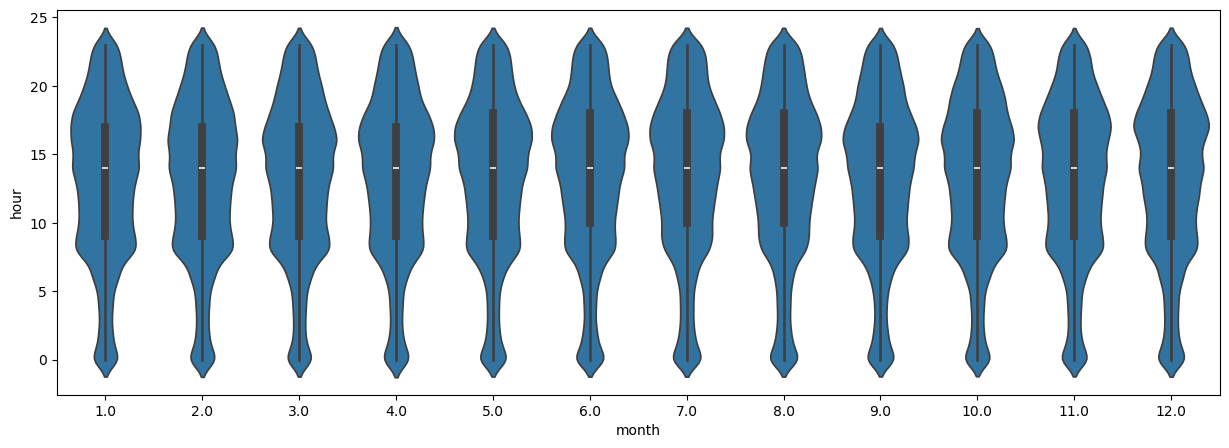

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
sns.violinplot(
    crashes_road.dropna(subset=["month"]), x="month", y="hour", bw_adjust=1.5
)

The distribution of crashes in NYC during the day does not change much from month to month, but it is clear that there are more crashes during peak times.

In [87]:
number_of_months = len(crashes_road[["month", "year"]].drop_duplicates())
number_of_months

142

In [88]:
crashes_road.columns
columns_to_grouby = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "road_geom",
    "st_width",
    "postvz_sl",
    "humps",
    "hour",
]

In [89]:
crashes_road["crashes"] = crashes_road.hour.apply(lambda o: not np.isnan(o))

In [90]:
crashes_road_hour_count = crashes_road.groupby(
    by=columns_to_grouby, as_index=False, dropna=False
)["crashes"].sum()

In [91]:
crashes_road_hour_count.sort_values("crashes", ascending=False)

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,hour,crashes
970460,1,NaN,474.559662707,TW,"POLYGON ((1012988.272 185000.542, 1012988.723 ...","MULTILINESTRING ((1012865.703 185460.115, 1012...",60.0,25.0,0.0,16.0,124
1127392,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,8.0,122
1183292,1,NaN,718.071632481,FT,"POLYGON ((994151.618 216413.573, 994154.291 21...","MULTILINESTRING ((993507.232 216732.034, 99413...",35.0,25.0,0.0,17.0,120
1127401,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,17.0,116
1022997,1,NaN,524.287333558,TW,"POLYGON ((1012888.646 185509.624, 1012889.094 ...","MULTILINESTRING ((1012757.078 186018.143, 1012...",60.0,25.0,0.0,16.0,110
...,...,...,...,...,...,...,...,...,...,...,...
1429118,7,NaN,8.41420667183,NV,"POLYGON ((1003204.979 242706.433, 1003206.287 ...","MULTILINESTRING ((1003231.565 242686.736, 1003...",0.0,25.0,0.0,NaN,0
1429119,7,NaN,80.1321793309,NV,"POLYGON ((1005290.635 243795.567, 1005287.822 ...","MULTILINESTRING ((1005376.876 243792.807, 1005...",18.0,25.0,0.0,NaN,0
1429120,7,NaN,80.3884137736,NV,"POLYGON ((1005216.971 243827.749, 1005214.158 ...","MULTILINESTRING ((1005303.447 243824.890, 1005...",18.0,25.0,0.0,NaN,0
1429121,7,NaN,81.8783963972,NV,"POLYGON ((1006626.143 250052.108, 1006623.703 ...","MULTILINESTRING ((1006711.118 250029.585, 1006...",0.0,25.0,0.0,NaN,0


In [92]:
crashes_road_hour_count["crashes"] = (
    crashes_road_hour_count["crashes"] / number_of_months
)

In [93]:
from pathlib import Path


def save_dataset(dataframe: pd.DataFrame | gpd.GeoDataFrame, file_name: str):
    data_folder = Path("./data")
    os.makedirs(data_folder, exist_ok=True)
    dataframe.to_csv(data_folder / file_name, index=False)

In [94]:
crashes_road_hour_count.drop(columns=["geometry", "road_geom"], inplace=True)

save_dataset(crashes_road_hour_count, "crashes_avg.csv")

#### Further comments

- Not all streets will have data for all times of the day. We may want to think about whether we should add one row per hour per street. The new added rows will have 0 crashes. 